# Exercise 1.2.3: Geometric Transformations
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Implement horizontal flipping and resizing;
* Implement random cropping (optional);
* Transform the associated bounding boxes.

## 1. Introduction

In our last [Exercise 1.2.2](), we performed pixel-level transformations on a set of images. In this Exercise, we will be manipulating the entire image space with geometric transformations. These type of transformations map every pixel in image to a new location via a mathematical function.

In [1]:
### Importing required modules

In [2]:
import copy
import logging
from math import floor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
from PIL import Image, ImageDraw
from typing import List

In [3]:
### Setting environment variables

In [4]:
ENV_COLAB = False                # True if running in Google Colab instance

In [5]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [6]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

### 1.1. Geometric Transformations

Geometric transformations 

There are five common classifications of [geometric transformations](https://en.wikipedia.org/wiki/Geometric_transformation) —
* **[Displacements](https://en.wikipedia.org/wiki/Displacement_\(vector\))**: preserve [distances](https://en.wikipedia.org/wiki/Distance) and _oriented_ [angles](https://en.wikipedia.org/wiki/Euclidean_space#Angle);
* **[Isometries](https://en.wikipedia.org/wiki/Isometry)**: preserve angles and distances;
* **[Similarities](https://en.wikipedia.org/wiki/Similarity_\(geometry\))**: preserve angles and ratios between distances;
* **[Affine transformations](https://en.wikipedia.org/wiki/Affine_transformation)**: preserve [parallelism](https://en.wikipedia.org/wiki/Parallelism_\(geometry\));
* **[Projective transformations](https://en.wikipedia.org/wiki/Homography)**: preserve [collinearity](https://en.wikipedia.org/wiki/Collinearity_\(geometry\)).

In this exercise we will work with several geometric transformations mentioned above. Namely — 
* **Similarities** to perform _resizing_;
* **Affine transformations** to perform horizontal and vertical _shearing_;
* **Euclidean transformations** (isometries) to perform _rotations_ and _reflections_.

In this exercise, you will implement the following geometric transformations
from scratch: horizontal flipping and resizing in `augmentations.py`. You can also 
implement random cropping as an additional but not required exercise. Your 
implementations should not only affect the images but also the associated bounding boxes. 

![](data/example.png)

## 2. Programming Task

In [7]:
def get_data(file_path: str) -> List[dict]:
    """Simple wrapper function to get JSON data."""

    try:
        with open(file_path) as f:
            ground_truth = json.load(f)
            return ground_truth
    except json.JSONDecodeError as jde:
        logging.error(jde)

In [8]:
### Fetching the bounding box data from JSON object 

In [9]:
file_path_gt = os.path.join(DIR_SRC, 'ground_truth.json')

In [10]:
ground_truth = get_data(file_path_gt)

In [11]:
def get_gt_bboxes(filename: str, ground_truth: List[dict],
                  flip_xy=False) -> tuple:
    """Returns the ground truth bounding box data for a given image.
    
    :param filename: the filename of image to fetch data for
    :param ground_truth: the parsed ground truth data
    :param flip_xy: indicates whether or not to flip x-y coordinates
    :returns: tuple of `np.ndarray` objects containing the 
        ground truth bounding boxes and corresponding class labels.
    """
    
    def flip_coordinates(bboxes: List[List[float]]) -> List[List[float]]:
        """Returns the flipped x,y coordinates."""
        return [[bbox[1], bbox[0], bbox[3], bbox[2]]
                for bbox in bboxes]
    try:
        gt_bboxes = [g['boxes'] if not flip_xy else
                     flip_coordinates(g['boxes']) for g in ground_truth
                     if g['filename'] == filename][0]
        gt_bboxes = np.array(gt_bboxes)
        gt_classes = [g['classes'] for g in ground_truth
                      if g['filename'] == filename][0]
        gt_classes = np.array(gt_classes)
    except Exception as e:
        # Logging IndexError (filename not found) as warning
        logging.warnings.warn(message=str(filename) + str(e))
    return gt_bboxes, gt_classes

**Note**: the provided 2D bounding box data has flipped $x$- and $y$-coordinate values such that
$$
\begin{align}
    \texttt{gt_bbox} = \texttt{[x1, y1, x2, y2]},
    \end{align}
$$
is now given as
$$
\begin{align}
    \texttt{gt_bbox} = \texttt{[y1, x1, y2, x2]}.
    \end{align}
$$

This has been acknowledged by the Udacity staff as an error in [this](https://knowledge.udacity.com/questions/824519) Knowledge forum post. We've covered the necessary transformation to revert coordinate pairs back to the expected form in Sect. 2.1 of [Exercise 1.1.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-1-2-Data-Acquisition-Visualisation/2022-08-01-Data-Acquisition-Visualisation.ipynb) so we're including it in the `get_gt_bboxes()` method without explicit mention.

we are inverting (swapping) $x$- and $y$-coordinate values in the provided bounding boxes data

In [12]:
### From Udacity's `utils.py`

In [13]:
def display_results(img: Image, bboxes: List[List[float]], 
                    aug_img: Image, aug_bboxes: List[List[float]]):
    """Displays the original and augmented image and bounding boxes.
    
    :param img: the PIL.Image object of the original (unmodified) image
    :param bboxes: the list of original (unmodified) bounding box coordinates
    :param aug_img: the augmented (modified) PIL.Image object
    :param aug_bboxes: the list of augmented (modified) bounding box coordinates
    """
    
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img)
    for bb in bboxes:
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r')
        ax[0].add_patch(rec)
    
    ax[1].imshow(aug_img)
    for bb in aug_bboxes:
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r')
        ax[1].add_patch(rec)
    plt.show()

### 2.1. Affine Transformations

#### 2.1.1. Euclidean transformation — Reflection 

The `hflip` function takes the image and bounding boxes as input and performs a 
horizontal flip. For example, an object initially on the left of the image will 
end up on the right.

In [14]:
### From Udacity's `augmentations.py`

In [15]:
def hflip(img: Image, bboxes: List[List[float]]) -> (Image, List[List[float]]):
    """Horizontally-flips the input image and bounding boxes.
    
    :param img: the PIL image object to flip horizontally
    :param bboxes: the list of original (unmodified) bounding box coordinates
    :returns: a tuple containing the augmented (modified) PIL.Image object
        and the list of augmented (modified) bounding box coordinates.
    """
    
    # IMPLEMENT THIS FUNCTION
    flipped_img = None
    flipped_bboxes = []
    # Load in the input image
    img_data = img.load()
    # Create the output image
    flipped_img = Image.new('RGB', img.size)
    img_draw = ImageDraw.Draw(flipped_img)
    # Perform the horizontal reflection of image points
    for u in range(flipped_img.width):
        for v in range(flipped_img.height):
            # Reverse the pixel horizontally
            u_p = img.width - u - 1
            # Add the reversed pixel to the output image
            img_draw.point(xy=(u, v), fill=img_data[u_p, v])
    # Peform horizontal flip on bounding box coordinates
    #bboxes = deque(bboxes)
    for bbox in bboxes:
        assert len(bbox) == 4
        # Assume data in [y1, x1, y2, x2] ordering
        x1_p = img.width - bbox[1]
        x2_p = img.width - bbox[3]
        flipped_bboxes.append([bbox[0], x1_p, bbox[2], x2_p])
    return flipped_img, flipped_bboxes

In [16]:
### Testing horizontal flip on first image in dataset
file_name_img = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img = os.path.join(DIR_SRC, f'images/{file_name_img}')

In [17]:
### Getting the image ground truth data
gt_bboxes, gt_classes = get_gt_bboxes(file_name_img, ground_truth)

In [18]:
### Staging the image for reading with PIL
img = Image.open(file_path_img)

In [19]:
### Performing the horizontal flip of the image and its bounding boxes
flipped_img, flipped_bboxes = hflip(img, gt_bboxes)

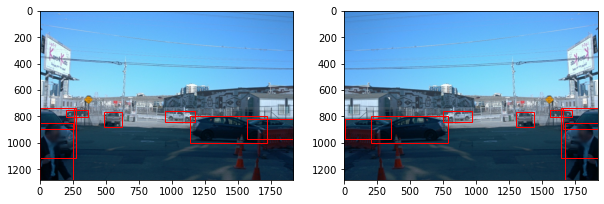

In [20]:
### Displaying the original and flipped image and bounding boxes
display_results(img, gt_bboxes, flipped_img, flipped_bboxes)

#### 2.1.2. Similarity transformation — Resizing

The `resize` function takes the image, bounding boxes and target size as input. 
It scales up or down images and bounding boxes.


In [21]:
### From Udacity's `augmentations.py`

In [22]:
def resize(img: Image, bboxes: List[List[float]], 
           target_size: List[int]) -> (Image, List[List[float]]):
    """Resizes the image and bounding boxes to the target size.
    
    Resizing, i.e., scaling is performed with a nearest neighbors algorithm.
    
    :param img: the PIL.Image object to flip horizontally
    :param bboxes: the list of original (unmodified) bounding box coordinates
    :param target_size: the (width, height) of output (resized) image.
    :returns: a tuple containing the augmented (modified) PIL.Image object
        and the list of augmented (modified) bounding box coordinates.
    """
    
    # IMPLEMENT THIS FUNCTION
    resized_img = None
    resized_bboxes = []
    assert len(target_size) == 2
    # Read in the image data
    img_data = img.load()
    # Create the output image
    resized_img = Image.new('RGB', target_size)
    img_draw = ImageDraw.Draw(resized_img)
    # Scale the original image dimensions
    x_scale = img.width / resized_img.width
    y_scale = img.height / resized_img.height
    # Scaling the image to target size
    for u in range(resized_img.width):
        for v in range(resized_img.height):
            u_p, v_p = floor(u * x_scale), floor(v * y_scale)
            img_draw.point(xy=(u, v), fill=img_data[u_p, v_p])
    # Scaling the bounding boxes to target size
    for bbox in bboxes:
        y1_p = floor(bbox[0] / y_scale)
        x1_p = floor(bbox[1] / x_scale)
        y2_p = floor(bbox[2] / y_scale)
        x2_p = floor(bbox[3] / x_scale)
        resized_bboxes.append([y1_p, x1_p, y2_p, x2_p])
    return resized_img, resized_bboxes

In [23]:
### Testing resize on first image in dataset
file_name_img_to_resize = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img_to_resize = os.path.join(DIR_SRC, f'images/{file_name_img_to_resize}')

In [24]:
### Getting the image ground truth data
gt_bboxes_to_resize, gt_classes_to_resize = get_gt_bboxes(file_name_img_to_resize, ground_truth)

In [25]:
### Staging the image for reading with PIL
img_to_resize = Image.open(file_path_img_to_resize)

In [26]:
### Performing the resizing of the image and its bounding boxes
#target_size = [img_to_resize.width // 2, img_to_resize.height // 2]
target_size = [640, 640]
resized_img, resized_bboxes = resize(img_to_resize, gt_bboxes_to_resize, target_size)

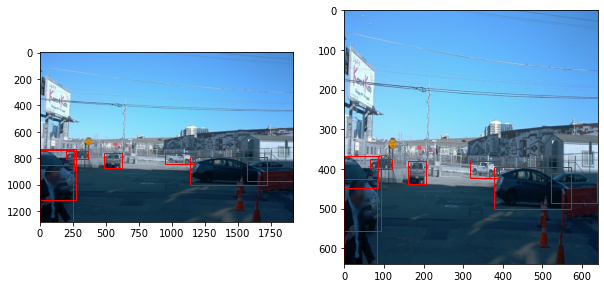

In [27]:
### Displaying the original and flipped image and bounding boxes
display_results(img_to_resize, gt_bboxes_to_resize, resized_img, resized_bboxes)

In [28]:
print('Original size:', img_to_resize.size, '\nOutput size:  ', resized_img.size)

Original size: (1920, 1280) 
Output size:   (640, 640)


### 2.2. Other Transformations

#### 2.2.1. Cropping

The `random_crop` function takes a few additional inputs. It also needs the classes, 
the crop size and the minimum area. Let's explain these parameters:
* `crop_size` is the size of the crop. It should be smaller than the dimensions of the input image.
* `min_area` is the minimum area of a bounding boxes to be considered as an object after cropping.

In [29]:
### From Udacity's `augmentations.py`

In [30]:
def random_crop(img, boxes, crop_size, min_area=100):
    """
    random cropping of an image and annotations
    args:
    - img [PIL.Image]: original image
    - boxes [list[list]]: list of bounding boxes
    - crop_size [array]: 1x2 array [width, height]
    - min_area [int]: min area of a bbox to be kept in the crop
    returns:
    - cropped_img [PIL.Image]: resized image
    - cropped_boxes [list[list]]: resized bboxes
    """
    # IMPLEMENT THIS FUNCTION
    return cropped_image, cropped_boxes

Because we are cropping randomly, we may only keep a tiny portion of an object, in which
case the annotations will not be useful anymore. For example, in the image below, we may not want to keep the annotation of the cat because most of the animal's body is not visible.

![](data/cat_cropped.png)

**Note:** You'll need to use the "Desktop" button to view the visualizations of each augmentation.

In [31]:
# fix seed to check results
    
# open annotations
    
# filter annotations and open image
    
# check horizontal flip, resize and random crop

# use check_results defined in utils.py for this

## Tips

The `hflip` transform does not affect the x coordinates of the bounding boxes.

You will use the same ratio in `resize` for the image and the bounding boxes. 

To find which bounding box belongs to the cropped area, you can use the `calculate_iou`
function.

In [32]:
### From Udacity's `utils.py`

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image


def plot_histogram(img):
    """ plot channel-wise pixel value distribution """
    histogram = img.histogram()

    R = histogram[0:256]
    G = histogram[256:512]
    B = histogram[512:768]

    plt.plot(range(256), R, color='r')
    plt.fill_between(range(256), R, color='r', alpha=0.5)
    plt.plot(range(256), G, color='g')
    plt.fill_between(range(256), G, color='g', alpha=0.5)
    plt.plot(range(256), B, color='b')
    plt.fill_between(range(256), B, color='b', alpha=0.5)
    plt.show()

    
def check_results(img, boxes, aug_type, classes=None):
    if aug_type == 'hflip':
        imcheck = Image.open('data/augmented/flipped.png')
        bbcheck = np.load('data/augmented/flipped.npy')
        assert np.array_equal(np.array(imcheck), np.array(img)), 'Horizontal flip (img) is wrong!'
        assert np.array_equal(np.array(boxes), bbcheck), 'Horizontal flip (bbox) is wrong!'
        print('Horizontal flip is working')

    elif aug_type == 'resize':
        imcheck = Image.open('data/augmented/resized.png')
        bbcheck = np.load('data/augmented/resized.npy')
        assert np.array_equal(np.array(imcheck), np.array(img)), 'Resizing (img) is wrong!'
        assert np.array_equal(np.array(boxes), bbcheck), 'Resizing (bbox) is wrong!'
        print('Resizing is working')

    elif aug_type == 'random_crop':
        imcheck = Image.open('data/augmented/cropped.png')
        bbcheck = np.load('data/augmented/cropped_bb.npy')
        clcheck = np.load('data/augmented/cropped_cl.npy')
        assert np.array_equal(np.array(imcheck), np.array(img)), 'Cropping is wrong!'
        assert np.array_equal(np.array(boxes), bbcheck), 'Cropping is wrong!'
        assert np.array_equal(np.array(classes), clcheck), 'Cropping is wrong!'
        print('Cropping is working')
    return

In [34]:
### Loading test image and bboxes data to check results against
file_name_test = 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_79.png'
file_path_test = os.path.join(DIR_SRC, f'images/{file_name_test}')
img_test = Image.open(file_path_test)
gt_bboxes_test, gt_classes_test = get_gt_bboxes(file_name_test, ground_truth)

In [35]:
### Obtaining the horizontally-flipped test image and bounding boxes
flipped_img, flipped_bboxes = hflip(img_test, gt_bboxes_test)

In [37]:
# Testing the horizontal flip results with [y1, x1, y2, x2] order
check_results(flipped_img, flipped_bboxes, 'hflip', classes=gt_classes)

AssertionError: Horizontal flip (bbox) is wrong!

In [38]:
# Changing the coordinate ordering:
# from [y1, x1, y2, x2] to [y1, x2, y2, x1]
f2_boxes = [[fb[0], fb[3], fb[2], fb[1]] for fb in flipped_bboxes]

In [39]:
### Testing the horizontal flip results with [y1, x2, y2, x1] order
check_results(flipped_img, f2_boxes, 'hflip', classes=gt_classes)

Horizontal flip is working


~~Will be opening up a GitHub Issue and Udacity Knowledge forum post to address this error in the provided comparison data.~~

**Update 2022-08-25**: Issue [#5](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/issues/5) has been opened and [this](https://knowledge.udacity.com/questions/892314) Knowledge forum post has been created.

In [40]:
### Obtaining the resized image and bounding boxes
target_size = (640, 640)
resized_img, resized_bboxes = resize(img_test, gt_bboxes_test, target_size)

In [41]:
### Testing the resize results
check_results(img_to_resize, resized_bboxes, 'resize', classes=gt_classes_to_resize)

AssertionError: Resizing (img) is wrong!

In [42]:
### Testing the resized bounding boxes against provided data
np.array_equal(np.array(resized_bboxes), np.load('data/augmented/resized.npy'))

True

Again we seem to be running into another issue with the data provided to us by Udacity. Here we see that the resized image we computed is raising an `AssertionError` as it does not match the data provided to us by Udacity. However, the resized bounding boxes we computed match perfectly the data provided by Udacity. The previous discrepancy in their `flipped.npy` data has me suspicious about the trustworthiness of their `resized.npy` image data. 

Furthermore, we can see both images are of equal size:

In [43]:
print('Output size:    ', resized_img.size, '\nExpected size:  ', Image.open('data/augmented/resized.png').size)

Output size:     (640, 640) 
Expected size:   (640, 640)
